In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

2022-10-19 12:59:26.405299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 12:59:26.579018: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 12:59:27.277155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-19 12:59:27.277225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
model = tf.keras.models.load_model("models/model40_padding")

2022-10-19 12:59:28.771201: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-10-19 12:59:28.771240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ancoramsi1
2022-10-19 12:59:28.771250: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ancoramsi1
2022-10-19 12:59:28.771377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-10-19 12:59:28.771398: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-19 12:59:28.771404: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-10-19 12:59:28.771632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

In [3]:
N = 1000
size = 64
imgs = np.zeros((size, size, N))
heatmaps = np.zeros_like(imgs)

for i in range(N):
    imgs[:,:,i] = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=4)
    heatmaps[:,:,i] = GradCam(imgs[:,:,i], model, last_conv_layer_idx=-6, pred_index=0)
    

In [4]:
threshold = 0.5

thresholded_heatmaps = np.copy(heatmaps) / 255

thresholded_heatmaps[thresholded_heatmaps > threshold] = 1
thresholded_heatmaps[thresholded_heatmaps <= threshold] = 0


In [39]:
from sklearn.metrics import jaccard_score


jaccard_scores = np.zeros(N)
centre = size // 2
centre_distances = np.zeros(N)
bbox_range = 10
for i in range(N):
    #find centre of thresholded heatmap
    th_labels = measure.label(np.copy(thresholded_heatmaps[:,:,i]))
    th_centroid = pd.DataFrame(measure.regionprops_table(th_labels, properties=['centroid'])).to_numpy()
    centroid_y = int(th_centroid[0][0])
    centroid_x = int(th_centroid[0][1])

    bbox = np.zeros_like(imgs[:,:,0])
    #create image with bounding box
    y_lower = np.max([0, centroid_y - bbox_range])
    y_upper = np.min([size-1, centroid_y + bbox_range])
    x_lower = np.max([0, centroid_x - bbox_range])
    x_upper = np.min([size-1, centroid_x + bbox_range])
    bbox[y_lower:y_upper, x_lower:x_upper] = 1

    #occlude image according to bounding box
    occluded_img = np.copy(imgs[:,:,i])
    occluded_img[bbox == 0] = 0

    #extract the blobs from the occluded image and get their major axis lengths and centroid
    labeled_image = measure.label(occluded_img)
    props = pd.DataFrame(measure.regionprops_table(labeled_image, properties=['area', 'centroid']))

    #find ellipse index
    ellipse_idx = props.idxmax()[0] + 1

    #convert labeled image to binary, setting everything except ellipse to 0
    labeled_image[labeled_image != ellipse_idx] = 0
    labeled_image[labeled_image == ellipse_idx] = 1

    #compute jaccard score and add to array
    jaccard_scores[i] = jaccard_score(labeled_image.astype(int), thresholded_heatmaps[:,:,i].astype(int), average='micro')

    #compute distance of ellipse centroid to centre and add to array
    centroid_ellipse_y = props['centroid-0'][props.idxmax()[0]]
    centroid_ellipse_x = props['centroid-1'][props.idxmax()[0]]
    centre_distances[i] = np.sqrt((centroid_ellipse_x-32)**2+(centroid_ellipse_y-32)**2)




(array([109, 907]),)

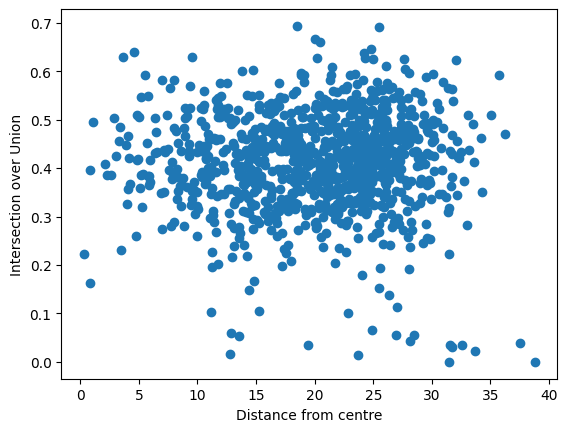

In [40]:
plt.scatter(centre_distances, jaccard_scores)
plt.xlabel('Distance from centre');
plt.ylabel('Intersection over Union');

np.where(jaccard_scores == 0)

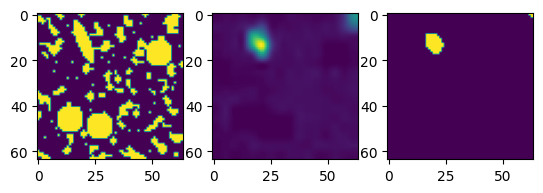

In [44]:
fig, ax = plt.subplots(1,3)
idx = 907
ax[0].imshow(imgs[:,:,idx])
ax[1].imshow(heatmaps[:,:,idx])
ax[2].imshow(thresholded_heatmaps[:,:,idx])

In [42]:
th_labels = measure.label(np.copy(thresholded_heatmaps[:,:,idx]))
th_centroid = pd.DataFrame(measure.regionprops_table(th_labels, properties=['centroid'])).to_numpy()
centroid_y = int(th_centroid[0][0])
centroid_x = int(th_centroid[0][1])


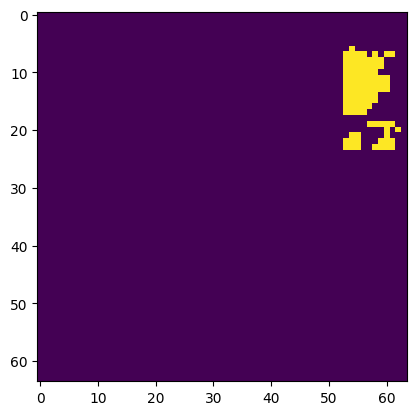

In [43]:
bbox = np.zeros_like(imgs[:,:,0])
bbox_range = 10
y_lower = np.max([0, centroid_y - bbox_range])
y_upper = np.min([size-1, centroid_y + bbox_range])
x_lower = np.max([0, centroid_x - bbox_range])
x_upper = np.min([size-1, centroid_x + bbox_range])
bbox[y_lower:y_upper, x_lower:x_upper] = 1

x = np.copy(imgs[:,:,idx])
x[bbox == 0] = 0
plt.imshow(x)

In [34]:
labels = measure.label(x)
props = pd.DataFrame(measure.regionprops_table(labels, properties=['area','centroid']))
props

,area,centroid-0,centroid-1
0,42,24.666667,30.595238
1,2,22.000000,36.500000
2,9,22.222222,42.888889
3,108,32.351852,37.953704
4,10,32.200000,45.500000
5,1,35.000000,30.000000
6,1,35.000000,43.000000
7,1,37.000000,40.000000
8,1,41.000000,43.000000


In [35]:
centroid_y = props['centroid-0'][props.idxmax()[0]]
centroid_x = props['centroid-1'][props.idxmax()[0]]

dist = np.sqrt((centroid_x-32)**2+(centroid_y-32)**2)
dist

5.964091508113097

In [36]:
ellipse_idx = props.idxmax()[0] + 1
ellipse_idx

4

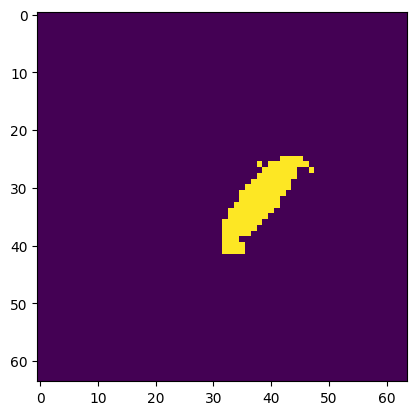

In [37]:
labels[labels != ellipse_idx] = 0
labels[labels == ellipse_idx] = 1
plt.imshow(labels)

0.4166666666666667

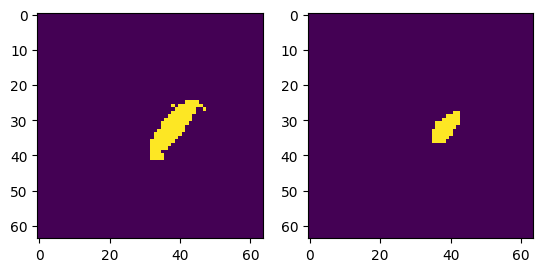

In [38]:
from sklearn.metrics import jaccard_score
fig,ax = plt.subplots(1,2)
ax[0].imshow(labels)
ax[1].imshow(thresholded_heatmaps[:,:,idx])
jaccard_score(labels.astype(int), thresholded_heatmaps[:,:,idx].astype(int), average='micro')